In [ ]:
# Install and import technical analysis library
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib as ta

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4497    0  4497    0     0  15403      0 --:--:-- --:--:-- --:--:-- 15453
100  517k  100  517k    0     0   497k      0  0:00:01  0:00:01 --:--:-- 1668k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4497    0  4497    0     0  18473      0 --:--:-- --:--:-- --:--:-- 18506
100  392k  100  392k    0     0   437k      0 --:--:-- --:--:-- --:--:-- 1041k


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Data Import and Inspection

In [ ]:
# Read in trading data
amc_trading = pd.read_csv("/content/drive/MyDrive/ESE 546 Principle of Deep Learning/Project/Trading data/AMC.csv",index_col="Date", parse_dates=True)
gme_trading = pd.read_csv("/content/drive/MyDrive/ESE 546 Principle of Deep Learning/Project/Trading data/GME.csv",index_col="Date", parse_dates=True)
btc_trading = pd.read_csv("/content/drive/MyDrive/ESE 546 Principle of Deep Learning/Project/Trading data/BTC-USD.csv",index_col="Date", parse_dates=True)
eth_trading = pd.read_csv("/content/drive/MyDrive/ESE 546 Principle of Deep Learning/Project/Trading data/ETH-USD.csv",index_col="Date", parse_dates=True)

In [ ]:
# Inspection
print(len(amc_trading))
amc_trading.head(5)

756


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,120.099998,130.800003,119.000000,128.899994,127.897476,137490
2019-01-03,128.000000,135.399994,126.300003,130.600006,129.584274,139240
2019-01-04,132.199997,136.899994,130.199997,135.399994,134.346924,102500
2019-01-07,135.500000,142.600006,133.699997,141.199997,140.101807,111920
2019-01-08,142.100006,147.000000,140.899994,145.699997,144.566833,112270


In [ ]:
print(len(btc_trading))
btc_trading.head(5)

1096


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990
2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836
2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219
2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467
2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824


<Axes: title={'center': "AMC's stock price"}, xlabel='Date'>

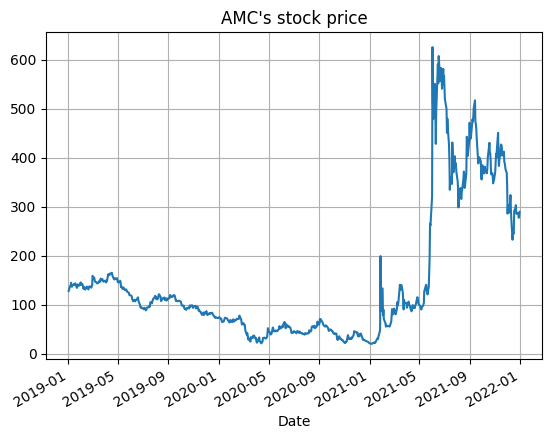

In [ ]:
# Plot price movement over time for a stock
amc_trading["Adj Close"].plot(title="AMC's stock price", grid=True)

In [ ]:
# Drop Close column; we will use Adj Close
amc_trading = amc_trading.drop(columns=["Close"])
gme_trading = gme_trading.drop(columns=["Close"])
btc_trading = btc_trading.drop(columns=["Close"])
eth_trading = eth_trading.drop(columns=["Close"])

In [ ]:
# Adjust the Volume to actual money for stocks but cryptocurrency (already in dollars)
amc_trading["Turnover"] = amc_trading["Adj Close"] * amc_trading["Volume"]
gme_trading["Turnover"] = gme_trading["Adj Close"] * gme_trading["Volume"]

# Drop Volume col
amc_trading = amc_trading.drop(columns=["Volume"])
gme_trading = gme_trading.drop(columns=["Volume"])

# Rename Volume col of cryptocurrency
btc_trading = btc_trading.rename(columns={"Volume":"Turnover"})
eth_trading = eth_trading.rename(columns={"Volume":"Turnover"})

## Compute Tachnical Indictors

In [ ]:
def feat_engineering(df, macd_params, adosc_params=[3,10], move_threshold=0.001, period_params=[5,10], avg_TR=7, corr_param=10):

  # Add col to indicate price movement; 2: up by at least move_threshold; 0: down by at least move_threshold; 1: otherwise
  df["Daily return"] = df["Adj Close"].pct_change()
  df["Target"] = pd.Series(np.where(df["Daily return"]>move_threshold, 1, np.where(df["Daily return"]<-move_threshold, -1,0)), index=df.index)

  # Forward timestamp by 1 as we can only have access to previous information
  target = df.loc[:, "Target"] # Target needs not to shift as they are ground truth
  df = df.drop(columns=["Target"]).shift()
  df = pd.concat([df, target], axis=1)

  # Overlap studies
  for param in period_params:
    # SMA
    col_name = "SMA_" + str(param)
    df[col_name] = ta.SMA(df["Adj Close"], param)

    # EMA
    col_name = "EMA_" + str(param)
    df[col_name] = ta.EMA(df["Adj Close"], param)

    # WMA
    col_name = "WMA_" + str(param)
    df[col_name] = ta.WMA(df["Adj Close"], param)


  # Momentum indictors
  for param in period_params:
    # RSI
    col_name = "RSI_" + str(param)
    df[col_name] = ta.RSI(df["Adj Close"], param)

    # MOM
    col_name = "MOM_" + str(param)
    df[col_name] = ta.MOM(df["Adj Close"], param)

    # ADX
    col_name = "ADX_" + str(param)
    df[col_name] = ta.ADX(df["High"], df["Low"], df["Adj Close"], param)

    # MACD
  df["MACD"], _, _ = ta.MACD(df["Adj Close"], macd_params[0], macd_params[1], macd_params[2])


  # Volume indictors
    # OBV
  df["OBV"] = ta.OBV(df["Adj Close"], df["Turnover"])

    # ADOSC
  df["ADOSC"] = ta.ADOSC(df["High"], df["Low"], df["Adj Close"], df["Turnover"], adosc_params[0], adosc_params[1])


  #Volatility Indicators
    # ATR (Average true range)
  df["ATR"] = ta.ATR(df["High"], df["Low"], df["Adj Close"], avg_TR)


  # Statistical functions
    # STD (Standard deviation)
  df["Close_STD"] = ta.STDDEV(df["Adj Close"]) # Default 5-day std

    # Correlaiton
  df["Corr"] = ta.CORREL(df["High"], df["Low"], corr_param)


  # Standardize all numerical input
  reserved_col_names = ["Daily return", "Target", "Corr"] # Cols that will not be normalized
  reserved_cols = df.loc[:, reserved_col_names]
  df = df.drop(columns=reserved_col_names)
  ser_list = []
  index = df.index

  for i in range(len(index)):
    # Normalization is performed over the past trading days; hence the loop
    # Cannot perform the standardization over the entire timeline as it will cause data leakage
    ser_list.append((df.iloc[i] - df.iloc[:i+1].mean()) / df.iloc[:i+1].std())

  df = pd.concat(ser_list, axis=1).T
  df.index = index
  df = pd.concat([df, reserved_cols], axis=1)
  df = df.dropna()

  return df

In [ ]:
macd_params = [12, 26, 7]

# Feature engineering and normalization
amc_trading_augmented_normal = feat_engineering(amc_trading, macd_params)
gme_trading_augmented_normal = feat_engineering(gme_trading, macd_params)
btc_trading_augmented_normal = feat_engineering(btc_trading, macd_params)
eth_trading_augmented_normal = feat_engineering(eth_trading, macd_params)

In [ ]:
# Save files
amc_trading_augmented_normal.to_csv("/content/drive/MyDrive/ESE 546 Principle of Deep Learning/Project/Trading data/AMC_withTA.csv", index=True)
gme_trading_augmented_normal.to_csv("/content/drive/MyDrive/ESE 546 Principle of Deep Learning/Project/Trading data/GME_withTA.csv", index=True)
btc_trading_augmented_normal.to_csv("/content/drive/MyDrive/ESE 546 Principle of Deep Learning/Project/Trading data/BTC-USD_withTA.csv", index=True)
eth_trading_augmented_normal.to_csv("/content/drive/MyDrive/ESE 546 Principle of Deep Learning/Project/Trading data/ETH-USD_withTA.csv", index=True)